# Calculate ECE and MCE 

Given probabilities of prediction from any machine learning algorithm (in a form of numpy array) with the predictions (in a form of one hot encoding)- calculate the ECE and MCE and plot the graph of the distribution.

input - <br>
preds - probabilities of the prediction <br>
example for 3 classes- 

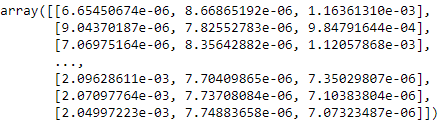

labels_oneh - predictions in one hot encoding <br>
example for 3 classes- 

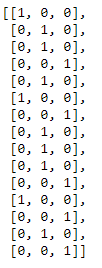

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from numpy.random import uniform, normal, shuffle

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_metrics(preds,labels_oneh):
    ECE = 0
    MCE = 0
    bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(preds,labels_oneh)

    for i in range(len(bins)):
        abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
        ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
        MCE = max(MCE, abs_conf_dif)

    return ECE, MCE

def calc_bins(preds,labels_oneh):
    # Assign each prediction to a bin
    num_bins = 5
    bins = np.linspace(0.1, 1, num_bins)
    binned = np.digitize(preds, bins)

    # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
#         print(preds[binned == bin])
        bin_sizes[bin] = len(preds[binned == bin])
        if bin_sizes[bin] > 0:
#             print(labels_oneh[binned==bin])
            bin_accs[bin] = (labels_oneh[binned==bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]

    return bins, binned, bin_accs, bin_confs, bin_sizes

import matplotlib.patches as mpatches

def draw_reliability_graph(preds,labels_oneh):
    ECE, MCE = get_metrics(preds,labels_oneh)
    bins, _, bin_accs, _, _ = calc_bins(preds,labels_oneh)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()

    # x/y limits
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1)

    # x/y labels
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')

    # Create grid
    ax.set_axisbelow(True) 
    ax.grid(color='gray', linestyle='dashed')

    # Error bars
    plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

    # Draw bars and identity line
    plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
    plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

    # Equally spaced axes
    plt.gca().set_aspect('equal', adjustable='box')

    # ECE and MCE legend
    ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
    MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
    plt.legend(handles=[ECE_patch, MCE_patch])

    #plt.show()

    plt.savefig('calibrated_network.png', bbox_inches='tight')


In [ ]:
### lets try to convert predictions to one_hot_encoding?
def convert_predictions_to_oneh(prediction)
"""
convert 3 class prediction to one hot encoding format
input - prediction (0 or 1 or 2)
output - new_oneh
"""
    new_oneh = []
    for pred in prediction.tolist():
        if pred == 0:
            new_oneh.append([1,0,0])
        if pred == 1:
            new_oneh.append([0,1,0])
        if pred == 2:
            new_oneh.append([0,0,1])
    return new_oneh

In [ ]:
new_oneh = convert_predictions_to_oneh(test_data['label'])
labels_oneh = np.array(new_oneh)
draw_reliability_graph(np.array(prob_total_list))

### note - in case you want to compere the results of the scaled logits- you should create the scaled logits after softmax (probabilities) and insert to the function

example of output - 

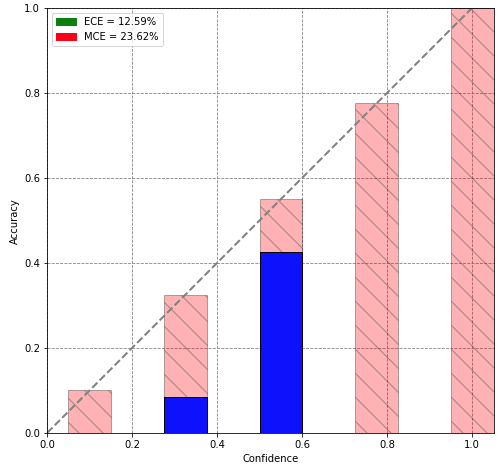

# Temperature scaling 

In a case you wish to calculate the ECE when you only have the logits, true labels and predicted labels, you can use the following functions

In [ ]:
def get_ece(predicted_posterior, predicted_label, true_label, R=20):
"""
calculate ECE
"""
    bin_size = 1/R
    total_sample = len(true_label)
    K = predicted_posterior.shape[1]

    score = 0
    for k in range(K):
        posteriors = predicted_posterior[:,k]
        sorted_indx = np.argsort(posteriors)
        for r in range(R):        
            indx = sorted_indx[r*R:(r+1)*R]
            predicted_label_ = predicted_label[indx]
            true_label_ = true_label[indx]

            indx_k = np.where(true_label_ == k)[0]
            acc = (
                np.nan_to_num(np.mean(predicted_label[indx_k] == k))
                if indx_k.size != 0
                else 0
            )
            conf = np.nan_to_num(np.mean(posteriors[indx_k])) if indx_k.size != 0 else 0
            score += len(indx) * np.abs(acc - conf)

    score /= (K*total_sample)
    return score

In [ ]:
def temperature_scale(logits, temperature):
"""
Scaling the logits with the given temperature
input - logits from any model, temperature - floaf number.
output - scaled array by gven temperature
"""
    temperature = np.ones_like(logits) * temperature
#     print(temperature)
    return logits / temperature

In [ ]:
def softmax_np(x):
"""
calculating softmax on array
input - x - array of logits
output - probs - array of probailies after softmax 
"""
    maxes = np.max(x, axis=1, keepdims=True)[0]
    x_exp = np.exp(x-maxes)
    x_exp_sum = np.sum(x_exp, 1, keepdims=True)
    probs = x_exp/x_exp_sum
    return probs

def ECE_temp_scaled_probability(temperature, logit_total_list, true_labels,predicted_labels):
"""
calculate ECE after scaling with temperature
input - temperature
output - the ECE score after scaling.
"""
    logits = np.array(logit_total_list)
    x = temperature_scale(logits, temperature)
    m = softmax_np(x)
    true_label = np.array(true_labels.tolist())
    predicted_label = np.array(predicted_labels)
    predicted_posterior = m
    score = get_ece(predicted_posterior, predicted_label, true_label, R=20)
    print(f"ECE score for T = {temperature} is -",score*100,"%")
    return m

In [ ]:
temp_1 = ECE_temp_scaled_probability(temperature = 1,logit_total_list,cleaned_test_df['label'],cat_list)
temp_2 = ECE_temp_scaled_probability(temperature = 2,logit_total_list,cleaned_test_df['label'],cat_list)

output example - <br>
ECE score for T = 1 is - 1.5152919617140699 %<br>
ECE score for T = 2 is - 13.158103320312936 %<br>